In [43]:
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

# 1 데이터 가공

In [44]:
users = pd.read_csv('선호도.csv')
users.head()

,Unnamed: 0,user,genre,like,dislike
0,0,0,"['일상', '개그', '판타지', '액션', '스릴러']","['가담항설', '모죠의 일지', '내일', '남과 여', '호러와 로맨스', '하...",['외모지상주의']
1,1,1,"['일상', '액션', '드라마', '스릴러']","['하르모니아', '하이브', '당신의 과녁', '유미의 세포들', '후기', '쌍...","['복학왕', '여신강림', '랜덤채팅의 그녀!', '뷰티풀 군바리', '프리드로우..."
2,2,2,"['개그', '판타지', '액션', '스릴러']","['모죠의 일지', '전지적 독자 시점', '신의 탑', '하루만 네가 되고 싶어'...","['복학왕', '내 ID는 강남미인!', '외모지상주의', '여신강림']"
3,3,3,"['일상', '개그', '판타지', '액션', '스릴러']","['가담항설', '싸우자귀신아', '하나의 하루', '내일', '호러와 로맨스', ...","['외모지상주의', '랜덤채팅의 그녀!', '여신강림']"
4,4,4,"['일상', '개그']","['딩스뚱스', '낢이 사는 이야기']",['nan']


In [45]:
users = users.drop(columns = ['Unnamed: 0', 'genre'], axis = 1)
users.tail(1)

,user,like,dislike
103,103,"['알고있지만', '연애혁명']",['nan']


In [46]:
from ast import literal_eval

In [47]:
preference = pd.DataFrame()
preference.tail(1)

""


In [48]:
# 좋아요: 1, 싫어요: -1, 안 본 웹툰: 0
for u in range(len(users)):
    like = literal_eval(users.loc[u, 'like'])
    dislike = literal_eval(users.loc[u, 'dislike'])
    
    for title in like:
        preference.loc[u, title] = 1
    
    for title in dislike:
        if title == 'nan':
            continue
        preference.loc[u, title] = -1

In [49]:
preference = preference.fillna(0)
preference.tail()

,가담항설,모죠의 일지,내일,남과 여,호러와 로맨스,하나의 하루,싸우자귀신아,외모지상주의,하르모니아,하이브,...,5kg을 위하여,유령극단,텃밭부 사건일지,스크립토리움,ㄹㅇ 관종,안녕 나의 모모로,모던패밀리,소나기야,공감.jpg,언터처블
99,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0
102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 2. 잠재요인 협업 필터링을 위한 함수 생성

### RMSE 계산 함수

In [50]:
def get_rmse(R, P, Q, non_zeros):
    error = 0
    
    # P와 Q.T의 내적으로 예측 R 행렬 생성
    full_pred_matrix = np.dot(P, Q.T)
    
    # 실제 R 행렬에서 Null이 아닌 값의 위치 인덱스 추출
    # 실제 R 행렬과 예측 행렬의 RMSE 계산
    x_nonzero_ind = [non_zero[0] for non_zero in non_zeros]
    y_nonzero_ind = [non_zero[1] for non_zero in non_zeros]
    R_non_zeros = R[x_non_zero_ind, y_non_zero_ind]
    full_pred_matrix_non_zeros = full_pred_matrix[x_nonzero_ind, y_nonzero_ind]
    
    mse = mean_squared_error(R_non_zeros, full_pred_matrix_non_zeros)
    rmse = np.sqrt(mse)
    
    return rmse

### Matrix Factorization

In [51]:
# Matrix Facotrizaiton
########################################
## R: 원본 사용자 - 아이템 평점 행렬  ##
## K: 잠재 요인의 차원 수             ##
## steps: SGD의 반복횟수              ##
## leraning_rate: 학습률              ##
## r_lambda: L2 규제 계수             ##
########################################

def mf(R, K, steps=200, learning_rate=0.01, r_lambda=0.01):
    num_users, num_items = R.shape
    
    # 1. P와 Q 매트릭스의 크기를 지정하고 정규 분포를 가진 랜덤 값 입력
    np.random.seed(1)
    P = np.random.normal(scale=1./K, size=(num_users, K))
    Q = np.random.normal(scale=1./K, size=(num_items, K))
    
    prev_rmse = 10000
    break_cnt = 0
    
    # R>0인 행 위치, 열 위치, 값을 non_zeros list object에 저장
    non_zeros = [(i,j,R[i,j]) for i in range(num_users) for j in range(num_items) if R[i,j]>0]
    
    # SGD기법으로 P와 Q 매트릭스를 계속 업데이트
    for step in range(steps):
        for i,j,r in non_zeros:
            # 실제 값과 예측 값의 차이인 오류값 구함
            eij = r - np.dot(P[i,:], Q[j,:].T)
            # Regularization을 반영한 SGD 업데이트 공식 적용
            P[i,:] = P[i,:] + learning_rate*(eij*Q[j,:] - r_lambda * P[i, :])
            Q[j,:] = Q[j,:] + learning_rate*(eij*P[i,:] - r_lambda * Q[j, :])
            
        rmse = get_rmse(R, P, Q, non_zeros)
        if (step%10) == 0:
            print("### iteration step: ", step, " rmse: ", rmse)
        
    return P, Q

### unseen

In [52]:
def get_unseen(ratings_matrix, userId):
    user_rating = ratings_matrix.loc[userId, :]
    
    already_seen = user_rating[user_rating > 0].index.tolist()
    webtoon_list = ratings_matrix.columns.tolist()
    
    unseen_list = [w for w in webtoon_list if w not in already_seen]
    
    return unseen_list

In [118]:
def recomm_webtoon_by_userid(pred_df, userId, unseen_list, top_n=5):
    #recomm = pred_df.loc[userId, unseen_list].sort_values(ascending=False)[:top_n]
    recomm = pred_df.loc[userId, unseen_list].sort_values(ascending=False)
    recomm = recomm[recomm > 0.8][:top_n]
    return recomm

In [119]:
ratings=preference

### 결측치 0으로 대체

In [120]:
ratings = ratings.fillna(0)
ratings.head(1)

,가담항설,모죠의 일지,내일,남과 여,호러와 로맨스,하나의 하루,싸우자귀신아,외모지상주의,하르모니아,하이브,...,5kg을 위하여,유령극단,텃밭부 사건일지,스크립토리움,ㄹㅇ 관종,안녕 나의 모모로,모던패밀리,소나기야,공감.jpg,언터처블
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [121]:
P, Q = mf(ratings.values, K=8, steps=200, learning_rate=0.006, r_lambda=0.01)
pred_matrix = np.dot(P, Q.T)

### iteration step:  0  rmse:  0.998974827056926
### iteration step:  10  rmse:  0.9820565088109389
### iteration step:  20  rmse:  0.9596676258049307
### iteration step:  30  rmse:  0.926200952318155
### iteration step:  40  rmse:  0.8794531349442775
### iteration step:  50  rmse:  0.8260181815469558
### iteration step:  60  rmse:  0.7724914923805748
### iteration step:  70  rmse:  0.7180669373368034
### iteration step:  80  rmse:  0.6620721883410895
### iteration step:  90  rmse:  0.6060414448677421
### iteration step:  100  rmse:  0.5515442219494653
### iteration step:  110  rmse:  0.4995825137253344
### iteration step:  120  rmse:  0.45083667327220894
### iteration step:  130  rmse:  0.40572153965703733
### iteration step:  140  rmse:  0.36435716998106144
### iteration step:  150  rmse:  0.32663997509982434
### iteration step:  160  rmse:  0.2923644065521446
### iteration step:  170  rmse:  0.26130969021043754
### iteration step:  180  rmse:  0.23327191756970564
### iteration step:

In [122]:
ratings_pred_matrix = pd.DataFrame(data=pred_matrix, index=ratings.index, columns = ratings.columns)
ratings_pred_matrix.head(3)

,가담항설,모죠의 일지,내일,남과 여,호러와 로맨스,하나의 하루,싸우자귀신아,외모지상주의,하르모니아,하이브,...,5kg을 위하여,유령극단,텃밭부 사건일지,스크립토리움,ㄹㅇ 관종,안녕 나의 모모로,모던패밀리,소나기야,공감.jpg,언터처블
0,1.034208,0.989461,1.029109,0.878779,1.003976,1.028022,0.978719,-0.423947,0.298072,0.494904,...,0.167956,-0.111308,0.148073,-0.221221,0.376925,0.140842,0.110691,-0.029720,-0.279743,-0.222464
1,0.945753,0.694444,0.897556,0.710769,0.951415,0.654592,0.732241,-0.118103,0.943546,0.999152,...,-0.244853,-0.478567,-0.170972,-0.621829,-0.180358,-0.020153,-0.227741,-0.167603,-0.597185,-0.564784
2,1.195139,0.821354,0.837085,0.501415,0.286584,0.662327,0.713717,0.733036,-0.062928,0.102184,...,0.413699,0.373230,0.486888,0.201806,0.534321,0.411237,0.471513,0.506933,0.109686,0.050973


### 각 사용자 선호 웹툰 & 추천 웹툰

In [126]:
for i in range(len(pred_matrix)):
    user_pref_id = preference.loc[i, :]
    print(f'  user{i}이(가) 좋아하는 웹툰')
    print(user_pref_id[user_pref_id > 0].sort_values(ascending = False))
    
    # i번째 사용자
    unseen_list = get_unseen(ratings, i)
    #잠재 요인 협업 필터링으로 웹툰 추천
    recomm = recomm_webtoon_by_userid(ratings_pred_matrix, i, unseen_list, top_n=5)
    #평점 데이터를 DataFrame으로 생성
    recomm = pd.DataFrame(data = recomm.values, index=recomm.index, columns=['pred_score'])
    print(f'\n{recomm}\n------------------------------------------------------------------')

  user0이(가) 좋아하는 웹툰
가담항설       1.0
모죠의 일지     1.0
내일         1.0
남과 여       1.0
호러와 로맨스    1.0
하나의 하루     1.0
싸우자귀신아     1.0
Name: 0, dtype: float64

         pred_score
소녀의 세계     1.191777
유미의 세포들    1.090566
마음의소리      1.017164
------------------------------------------------------------------
  user1이(가) 좋아하는 웹툰
하르모니아            1.0
하이브              1.0
당신의 과녁           1.0
유미의 세포들          1.0
후기               1.0
쌍갑포차             1.0
파이게임             1.0
머니게임             1.0
노네임드(NoNameD)    1.0
Name: 1, dtype: float64

         pred_score
마음의소리      1.037825
놓지마 정신줄    1.022939
입학용병       0.986547
소녀의 세계     0.981998
여주실격!      0.969169
------------------------------------------------------------------
  user2이(가) 좋아하는 웹툰
모죠의 일지          1.0
전지적 독자 시점       1.0
신의 탑            1.0
하루만 네가 되고 싶어    1.0
겟백              1.0
죽음에 관하여         1.0
윈드브레이커          1.0
Name: 2, dtype: float64

          pred_score
연애혁명        1.229826
가담항설        1.195139
바른연애 길잡이    1.165272
피라미드 게임     1


              pred_score
가담항설            1.003254
바른연애 길잡이        0.983160
세기말 풋사과 보습학원    0.832309
모죠의 일지          0.801582
------------------------------------------------------------------
  user49이(가) 좋아하는 웹툰
치즈인더트랩        1.0
간 떨어지는 동거     1.0
N번째 연애        1.0
그들이 사귀는 세상    1.0
Name: 49, dtype: float64

             pred_score
이번 생도 잘 부탁해    1.003379
연애혁명           1.002808
------------------------------------------------------------------
  user50이(가) 좋아하는 웹툰
모죠의 일지    1.0
Name: 50, dtype: float64

Empty DataFrame
Columns: [pred_score]
Index: []
------------------------------------------------------------------
  user51이(가) 좋아하는 웹툰
신의 탑     1.0
마음의소리    1.0
노블레스     1.0
Name: 51, dtype: float64

              pred_score
대학일기            1.139930
아홉수 우리들         0.985571
세기말 풋사과 보습학원    0.985118
알고있지만           0.856975
바른연애 길잡이        0.823905
------------------------------------------------------------------
  user52이(가) 좋아하는 웹툰
복학왕       1.0
연애혁명      1.0
치즈인더트랩    1.0
Name: 5

------------------------------------------------------------------


### 통계

In [111]:
max(ratings_pred_matrix.max()), min(ratings_pred_matrix.min())

(1.732633614653428, -1.1466824946592094)

In [112]:
x_axis = np.arange(1.7, -1.3, -0.1)
count = [0] * len(x_axis)
x = np.arange(len(x_axis))

for i in range(len(x_axis)):
    x_axis[i] = '{:.2f}'.format(x_axis[i])
    
for i in range(len(users)):
    unseen_list = get_unseen(ratings, i)
    recomm = recomm_webtoon_by_userid(ratings_pred_matrix, i, unseen_list, top_n=5)
    recomm = pd.DataFrame(data = recomm.values, index=recomm.index, columns=['pred_score'])
    
    for k in range(len(recomm)):
        idx = recomm.iloc[k, 0] // 0.1
        if idx > 0:
            count[17-int(idx)] += 1
        else:
            count[abs(int(idx))+17] += 1

In [113]:
import matplotlib.pyplot as plt

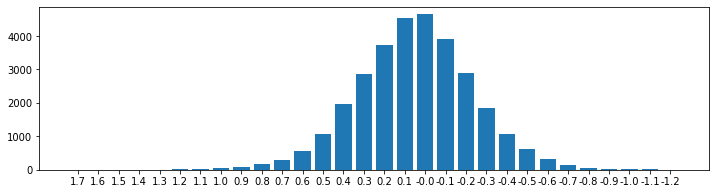

In [114]:
plt.figure(figsize=(12, 3))
plt.bar(x, count)
plt.xticks(x, x_axis)

plt.show()

In [115]:
print(count)

[1, 1, 0, 4, 8, 10, 22, 54, 93, 176, 306, 569, 1072, 1960, 2868, 3744, 4527, 4644, 3919, 2900, 1856, 1060, 616, 327, 137, 62, 37, 11, 10, 3]
